This file contains functions and an example of a product grouping by characteristics. We begin by defining the needed functions and importing data. Characteristics are manually defined as binary variables and added to a "product characteristic" matrix. We first attempt a MeanShift and OPTICS clustering of the products, followed by a custom algorithm.

The grouping is completed using a weighted Hamming Distance(https://en.wikipedia.org/wiki/Hamming_distance) to obtain similarity between products. Products that are similar, based on a similarity threhshold, are grouped. We can consider this function to be a simple clustering algorithm.

The similiarity threshold must be provided as an input. We find this value by analyzing the results of a threshold test, a silhouette score analysis. We can also use a hierarchical clustering as a secondary form of analysis.

Threshold/elbow method: We test a range of similarity threshold values in the grouping function. We plot our results against the number of groups found for each value, and look for any plateaus or sharp changes. 

Silhouette score analysis: We test a range of similarity threshold values in the grouping function and calculate the silhouette score for the resulting groups.This score provide us with an understanding of how well defined the groupings are. We analyze a plot of the similarity threshold values against the results silhouette scores to find an optimum threshold. 

Hierarchical clustering: This is a clustering algorithm that we apply to the products naively to get an understanding of how they group and visualize groupings with a dendrogram.

In [3]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist

from utils import *

In [4]:
#Function to group my hamming distance and similiarity threshold -------------------------------------------------

def group_samples_by_similarity_threshold(matrix, weights, similarity_threshold, columns, index):
    # Convert matrix to numpy array if it's not already
    matrix = np.array(matrix)
    weights = np.array(weights)
    
    # Calculate weighted Hamming similarity
    similarity_matrix = weighted_hamming_similarity(matrix, weights)
    
    # Create a DataFrame with the original data
    df = pd.DataFrame(matrix, columns=feature_cols, index=products)
    
    # Initialize groups
    groups = [-1] * len(matrix)
    current_group = 0
    
    for i in range(len(matrix)):
        if groups[i] == -1:
            # Start a new group
            groups[i] = current_group
            # Find all samples similar enough to be in this group
            similar_samples = np.where(similarity_matrix[i] >= similarity_threshold)[0]
            for j in similar_samples:
                if groups[j] == -1:
                    groups[j] = current_group
            current_group += 1
    
    df['group'] = groups
    
    return df

# def weighted_hamming_similarity(matrix, weights):
#     def weighted_hamming(u, v):
#         return np.sum(weights * (u == v)) / np.sum(weights)
    
#     distances = pdist(matrix, metric=lambda u, v: 1 - weighted_hamming(u, v))
#     return 1 - squareform(distances)

def weighted_hamming(u, v, weights):
    return np.sum(weights * (u == v)) / np.sum(weights)

def weighted_hamming_similarity(matrix, weights):
    distances = pdist(matrix, metric=lambda u, v: 1 - weighted_hamming(u, v, weights))
    return 1 - squareform(distances)

def analyze_products(matrix, weights, similarity_threshold=None, columns=None, index=None):
    # Convert matrix to numpy array if it's not already
    matrix = np.array(matrix)
    weights = np.array(weights)
    
    # Calculate weighted Hamming distances
    distance_matrix = weighted_hamming_similarity(matrix, weights)
    
    # Create a DataFrame with the original data
    df = pd.DataFrame(matrix, columns=columns, index=index)
    
    # Create a DataFrame for the distance matrix
    distance_df = pd.DataFrame(distance_matrix, columns=index, index=index)
    
    print("Weighted Hamming Distances:")
    print(distance_df)
    
    if similarity_threshold is not None:
        # Initialize groups
        groups = [-1] * len(matrix)
        current_group = 0
        
        for i in range(len(matrix)):
            if groups[i] == -1:
                # Start a new group
                groups[i] = current_group
                # Find all samples similar enough to be in this group
                similar_samples = np.where(distance_matrix[i] >= similarity_threshold)[0]
                for j in similar_samples:
                    if groups[j] == -1:
                        groups[j] = current_group
                current_group += 1
        
        df['group'] = groups
        
        # Print out common variables for each group
        for group in range(current_group):
            group_samples = df[df['group'] == group]
            common_vars = group_samples.iloc[:, :-1].apply(lambda x: len(set(x)) == 1)
            common_var_names = common_vars[common_vars].index.tolist()
            
            print(f"\nGroup {group}:")
            print(f"Samples: {', '.join(group_samples.index)}")
            print(f"Common variables: {', '.join(common_var_names)}")
        
        return df, distance_df
    else:
        return distance_df

#functions to help find appropriate threshold --------------------------------------------

def elbow_method(matrix, weights, thresholds, feature_cols, products):
    num_groups = []
    for threshold in thresholds:
        result = group_samples_by_similarity_threshold(matrix, weights, threshold, feature_cols, products)
        num_groups.append(result['group'].nunique())
    
    plt.plot(thresholds, num_groups, 'bo-')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Number of Groups')
    plt.title('Elbow Method')
    plt.show()

def silhouette_analysis(matrix, weights, thresholds):
    scores = []
    for threshold in thresholds:
        result = group_samples_by_similarity_threshold(matrix, weights, threshold, feature_cols, products)
        unique_groups = result['group'].nunique()

        if 1 < unique_groups < len(matrix):
            try:
                score = silhouette_score(matrix, result['group'])
                scores.append(score)
            except ValueError as e:
                print(f"Error at threshold {threshold}: {e}")
                scores.append(0)
        else:
            print(f"Invalid number of clusters ({unique_groups}) at threshold {threshold}. Skipping.")
            scores.append(0)
    
    plt.plot(thresholds, scores, 'bo-')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()

def hierarchical_clustering(matrix, weights):
    similarity_matrix = weighted_hamming_similarity(matrix, weights)
    linkage_matrix = linkage(1 - similarity_matrix, method='average')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Products')
    plt.ylabel('Distance')
    plt.show()

def dbscan_clustering(matrix, weights):
    similarity_matrix = weighted_hamming_similarity(matrix, weights)
    distances = 1 - similarity_matrix
    
    dbscan = DBSCAN(metric='precomputed', eps=0.5)  # Adjust eps as needed
    clusters = dbscan.fit_predict(distances)
    
    return clusters

#visualizations --------------------------------------------------------------------------

# Use this function after you've calculated the distances
def plot_product_distances(distance_df):
    # 1. Multidimensional Scaling (MDS)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_df)

    plt.figure(figsize=(10, 8))
    plt.scatter(mds_coords[:, 0], mds_coords[:, 1], marker='o')
    for i, product in enumerate(distance_df.index):
        plt.annotate(product, (mds_coords[i, 0], mds_coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points')
    plt.title('Product Distances - Multidimensional Scaling')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

    # 2. Heatmap with Hierarchical Clustering
    plt.figure(figsize=(12, 10))
    sns.clustermap(distance_df, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Product Distances - Heatmap with Hierarchical Clustering')
    plt.tight_layout()
    plt.show()

# Use this function after you've prepared your matrix
def perform_pca_analysis(matrix, feature_cols, products):
    # Convert categorical variables to dummy variables
    df = pd.DataFrame(matrix, columns=feature_cols, index=products)
    df_encoded = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == 'object'])
    
    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_encoded)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(data_scaled)
    
    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()
    
    # Plot first two principal components
    plt.figure(figsize=(12, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    for i, product in enumerate(products):
        plt.annotate(product, (pca_result[i, 0], pca_result[i, 1]), xytext=(5, 5), 
                     textcoords='offset points')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA of Products')
    plt.tight_layout()
    plt.show()
    
    # Return PCA results, the PCA object, and the encoded DataFrame
    return pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])], index=products), pca, df_encoded

def plot_loading_vectors(pca, feature_names):
    plt.figure(figsize=(12, 10))
    
    # Get the loading vectors
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create the scatter plot of loadings
    plt.scatter(loadings[:, 0], loadings[:, 1])
    
    # Add arrows
    for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
        plt.arrow(0, 0, x, y, color='r', alpha=0.5)
        plt.text(x, y, feature_names[i], fontsize=9)
    
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2f})")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2f})")
    plt.title("PCA Loading Plot")
    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
# Load the dataset
biomass_data = pd.read_csv('site_data.csv')

# Transpose the DataFrame to have products as rows and locations as columns
data_transposed = biomass_data.set_index(['dataset', 'site_name', 'site_id', 'X', 'Y']).T

# Remove non-numeric rows
data_transposed_numeric = data_transposed.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

data_imputed

dataset                    NEON                                             \
site_name        Harvard Forest Smithsonian Conservation Biology Institute   
site_id                    HARV                                       SCBI   
X                   -72.172660                                 -78.139500    
Y                     42.536900                                  38.892920   
ESA CCI               21.046901                                  21.046901   
Chopping et al.       18.783055                                  18.783055   
GEDI L4B             164.080719                                 334.279755   
Liu et al.            37.921211                                 115.212837   
LT-GNN                31.403246                                  31.403246   
Menlove & Healey     114.922806                                 106.782768   
Xu et al.             69.325028                                  69.325028   

dataset                                                         \
site_name        Ordway-Swisher Biological Station      UNDERC   
site_id                                       OSBS        UNDE   
X                                      -81.993430  -89.537250    
Y                                        29.689270   46.233880   
ESA CCI                                  21.046901   21.046901   
Chopping et al.                          18.783055   18.783055   
GEDI L4B                                 63.379155  155.069643   
Liu et al.                               69.890287  139.331772   
LT-GNN                                   31.403246   31.403246   
Menlove & Healey                         42.734001   91.699257   
Xu et al.                                69.325028   69.325028   

dataset                                                        \
site_name        Konza Prairie Biological Station   Oak Ridge   
site_id                                      KONZ        ORNL   
X                                     -96.563090  -84.282600    
Y                                       39.100770   35.964120   
ESA CCI                                 21.046901   21.046901   
Chopping et al.                         18.783055   18.783055   
GEDI L4B                                 7.477551  162.482702   
Liu et al.                              10.838812   91.845345   
LT-GNN                                  31.403246   31.403246   
Menlove & Healey                        10.135107  115.705890   
Xu et al.                               69.325028   69.325028   

dataset                                                 \
site_name        Talladega National Forest   Woodworth   
site_id                               TALL        WOOD   
X                              -87.393270  -99.241356    
Y                                32.950460   47.128228   
ESA CCI                          21.046901   21.046901   
Chopping et al.                  18.783055   18.783055   
GEDI L4B                        228.355491    4.161302   
Liu et al.                       85.784576    9.719982   
LT-GNN                           31.403246   31.403246   
Menlove & Healey                125.903267    0.000000   
Xu et al.                        69.325028   69.325028   

dataset                                                                    \
site_name        Central Plains Experimental Range LBJ National Grassland   
site_id                                       CPER                   CLBJ   
X                                      -104.745602            -97.570000    
Y                                        40.815534              33.401230   
ESA CCI                                  21.046901              21.046901   
Chopping et al.                           0.000000              18.783055   
GEDI L4B                                  1.268689              17.868778   
Liu et al.                                9.621728              11.764260   
LT-GNN                                   31.403246              31.403246   
Menlove & Healey      

In [6]:
products = ['ESA CCI', 'Chopping et al.', 'GEDI L4B', 'Liu et al.', 'LT-GNN', 'Menlove & Healey', 'Xu et al.', 'GFW', 'Harmonized Forest Biomass Spawn', 'ICESat-2 Boreal Biomass', 'Natl Biomass Carbon dataset']
sorted_products = sorted(products)
sorted_products

['Chopping et al.',
 'ESA CCI',
 'GEDI L4B',
 'GFW',
 'Harmonized Forest Biomass Spawn',
 'ICESat-2 Boreal Biomass',
 'LT-GNN',
 'Liu et al.',
 'Menlove & Healey',
 'Natl Biomass Carbon dataset',
 'Xu et al.']

In [7]:
products = ['ESA CCI', 'Chopping et al.', 'GEDI L4B', 'Liu et al.', 'LT-GNN', 'Menlove & Healey', 'Xu et al.']
feature_cols = ['multispec', 'lidar', 'micro','field','ML','forest_calib','tropical_calib','FIA','ALS','NEON','GSV','ICESAT','Saatchi','MISR']

#input data
multispec=np.array([1,1,0,1,1,0,1])
lidar=np.array([1,0,1,0,0,0,0])
micro=np.array([1,0,0,1,0,0,1])
field=np.array([0,0,0,0,1,1,0])
ML=np.array([1,0,0,0,1,0,1])

#calibration ecosys
forest=np.array([1,1,1,0,1,1,1])
tropical=np.array([1,0,0,1,0,0,1])

#calibdration data
FIA = np.array([0,0,1,0,1,1,1])
ALS = np.array([0,0,1,0,0,0,1])
NEON = np.array([0,0,1,0,0,0,0])
GSV = np.array([1,0,0,0,0,0,0]) #GSV/WD
ICESAT = np.array([1,0,0,0,0,0,1])
Saatchi= np.array([0,0,0,1,0,0,0])
MISR = np.array([0,1,0,0,0,0,0])

#Spatial Resolution


matrix_unlabeled=np.column_stack((multispec,lidar,micro,field,ML,forest,tropical,FIA,ALS,NEON,GSV,ICESAT,Saatchi,MISR))

In [8]:
matrix_unlabeled

array([[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]])

In [9]:
matrix = pd.DataFrame(matrix_unlabeled, columns=feature_cols, index=products)
matrix

,multispec,lidar,micro,field,ML,forest_calib,tropical_calib,FIA,ALS,NEON,GSV,ICESAT,Saatchi,MISR
ESA CCI,1,1,1,0,1,1,1,0,0,0,1,1,0,0
Chopping et al.,1,0,0,0,0,1,0,0,0,0,0,0,0,1
GEDI L4B,0,1,0,0,0,1,0,1,1,1,0,0,0,0
Liu et al.,1,0,1,0,0,0,1,0,0,0,0,0,1,0
LT-GNN,1,0,0,1,1,1,0,1,0,0,0,0,0,0
Menlove & Healey,0,0,0,1,0,1,0,1,0,0,0,0,0,0
Xu et al.,1,0,1,0,1,1,1,1,1,0,0,1,0,0


In [10]:
#attempt to cluster by features with meanshift

scaler = StandardScaler()
prod_data = scaler.fit_transform(matrix)

meanshift = MeanShift()
clusters = meanshift.fit_predict(prod_data)
labels = meanshift.labels_
print("meanshift Cluster labels:", clusters)

get_dist(prod_data, labels)

meanshift Cluster labels: [1 4 5 3 0 0 2]
Distances between cluster centers:
[[0.         6.11248722 5.01123737 5.97738795 4.40407009 5.01123737]
 [6.11248722 0.         4.69574275 6.19542842 6.19542842 6.88234456]
 [5.01123737 4.69574275 0.         5.85662019 5.85662019 5.92593171]
 [5.97738795 6.19542842 5.85662019 0.         5.71547607 7.17286554]
 [4.40407009 6.19542842 5.85662019 5.71547607 0.         5.92593171]
 [5.01123737 6.88234456 5.92593171 7.17286554 5.92593171 0.        ]]

Distances between data points and cluster centers:
Data point 0: [6.11248722 0.         4.69574275 6.19542842 6.19542842 6.88234456]
Data point 1: [4.40407009 6.19542842 5.85662019 5.71547607 0.         5.92593171]
Data point 2: [5.01123737 6.88234456 5.92593171 7.17286554 5.92593171 0.        ]
Data point 3: [5.97738795 6.19542842 5.85662019 0.         5.71547607 7.17286554]
Data point 4: [1.49861047 5.92593171 4.78191036 6.12916525 4.60796412 5.64358042]
Data point 5: [1.49861047 6.64078309 5.6435804

In [11]:
#Attempt to cluster with OPTICS

optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(prod_data)
labels = optics.labels_
print("optics Cluster labels:", clusters)

get_dist(prod_data, labels)

optics Cluster labels: [-1  0  0 -1  0  0 -1]
Distances between cluster centers:
[[0.         4.24539511]
 [4.24539511 0.        ]]

Distances between data points and cluster centers:
Data point 0: [5.68862168 3.10137365]
Data point 1: [3.27395021 4.9589052 ]
Data point 2: [3.6847094  5.84110593]
Data point 3: [5.57991189 3.70160126]
Data point 4: [2.57593025 4.6177997 ]
Data point 5: [2.14330352 5.25216005]
Data point 6: [4.70659998 2.8735705 ]


# Determine Similarity with hamming dist

Use a weighted hamming distance metric to group products by features

In [12]:
weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]

result = analyze_products(matrix, weights, similarity_threshold=None, columns=feature_cols, index=products)
# print(result)

Weighted Hamming Distances:
                   ESA CCI  Chopping et al.  GEDI L4B  Liu et al.    LT-GNN  \
ESA CCI           1.000000         0.500000  0.357143    0.571429  0.500000   
Chopping et al.   0.500000         1.000000  0.571429    0.642857  0.714286   
GEDI L4B          0.357143         0.571429  1.000000    0.357143  0.571429   
Liu et al.        0.571429         0.642857  0.357143    1.000000  0.500000   
LT-GNN            0.500000         0.714286  0.571429    0.500000  1.000000   
Menlove & Healey  0.357143         0.714286  0.714286    0.500000  0.857143   
Xu et al.         0.714286         0.500000  0.500000    0.571429  0.642857   

                  Menlove & Healey  Xu et al.  
ESA CCI                   0.357143   0.714286  
Chopping et al.           0.714286   0.500000  
GEDI L4B                  0.714286   0.500000  
Liu et al.                0.500000   0.571429  
LT-GNN                    0.857143   0.642857  
Menlove & Healey          1.000000   0.500000  
Xu 

In [13]:
df, distance_df = analyze_products(matrix, weights, similarity_threshold=0.55, columns=feature_cols, index=products)
df

Weighted Hamming Distances:
                   ESA CCI  Chopping et al.  GEDI L4B  Liu et al.    LT-GNN  \
ESA CCI           1.000000         0.500000  0.357143    0.571429  0.500000   
Chopping et al.   0.500000         1.000000  0.571429    0.642857  0.714286   
GEDI L4B          0.357143         0.571429  1.000000    0.357143  0.571429   
Liu et al.        0.571429         0.642857  0.357143    1.000000  0.500000   
LT-GNN            0.500000         0.714286  0.571429    0.500000  1.000000   
Menlove & Healey  0.357143         0.714286  0.714286    0.500000  0.857143   
Xu et al.         0.714286         0.500000  0.500000    0.571429  0.642857   

                  Menlove & Healey  Xu et al.  
ESA CCI                   0.357143   0.714286  
Chopping et al.           0.714286   0.500000  
GEDI L4B                  0.714286   0.500000  
Liu et al.                0.500000   0.571429  
LT-GNN                    0.857143   0.642857  
Menlove & Healey          1.000000   0.500000  
Xu 

,multispec,lidar,micro,field,ML,forest_calib,tropical_calib,FIA,ALS,NEON,GSV,ICESAT,Saatchi,MISR,group
ESA CCI,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0
Chopping et al.,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1
GEDI L4B,0,1,0,0,0,1,0,1,1,1,0,0,0,0,1
Liu et al.,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0
LT-GNN,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1
Menlove & Healey,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1
Xu et al.,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0


# Multidimensional Scaling (MDS):

This technique takes the high-dimensional distance matrix and projects it onto a 2D space.
Each point represents a product, and the distances between points approximate the original distances.
Products that are closer in the original space will be closer in this 2D representation.
This plot gives you a quick, intuitive view of which products are similar (close together) and which are different (far apart).


Heatmap with Hierarchical Clustering:

This visualization shows the pairwise distances between all products.
The color intensity represents the distance (darker colors usually indicate greater distances).
The hierarchical clustering (dendrogram on the sides) groups similar products together.
This plot is great for seeing the exact distances between any pair of products and for identifying clusters of similar products.

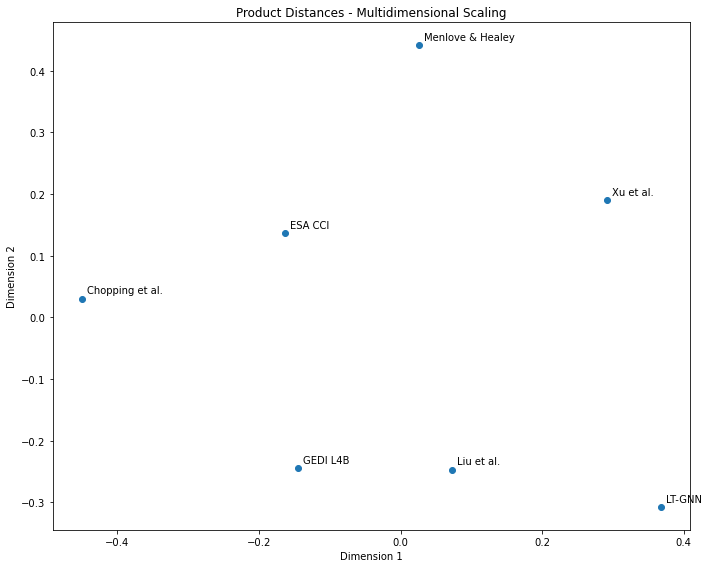

<Figure size 864x720 with 0 Axes>

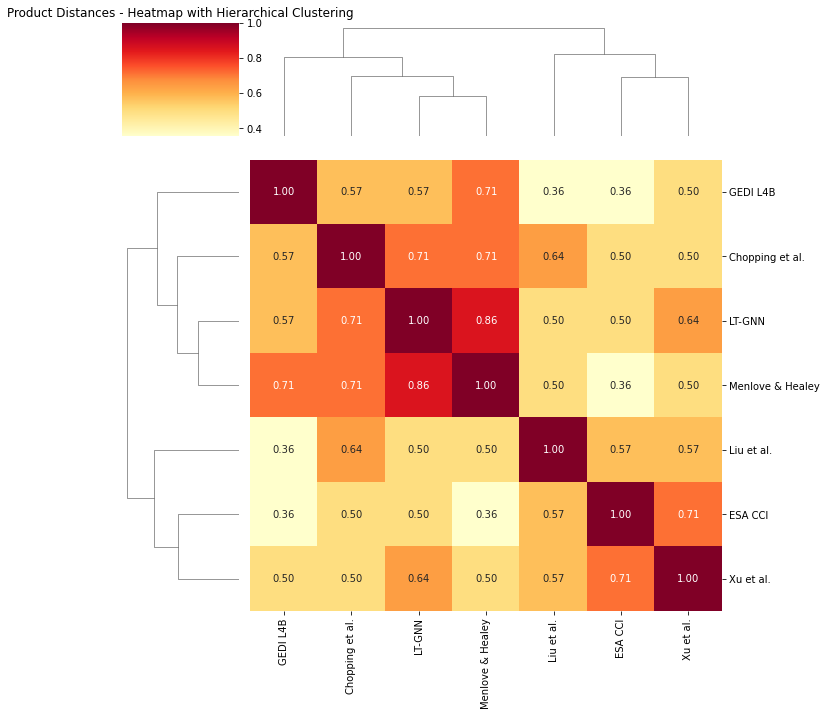

In [14]:
plot_product_distances(distance_df)

In MDS plot, the following are relatively close:

Chopping et al. and ESA CCI 

GEDI, Liu and LTGNN

Menlove is closest to ESA and Xu, and furthest from LT-GNN 

# PCA
MDS can give you a visualization that faithfully represents the distances you've calculated between products.
PCA, the focus is on capturing the maximum amount of variance in the data along each axis. can provide insights into which features are driving those differences and allow for a more interpretable reduced feature space.

Points that are close together represent items that are similar in terms of the principal components shown.
The direction of most spread in the points indicates the principal component that accounts for the most variance.
If the points form a pattern (like a curve), this suggests a relationship between the principal components

If a small number of principal components explain a large proportion of the variance, it suggests that the original variables are not independent.
If many components are needed to explain most of the variance, it suggests more independence among variables

Loadings show how much each original variable contributes to each principal component.
If variables are independent, you'd expect to see each variable contributing strongly to different components.
Variables that consistently load together on the same components are likely not independent.

## From Wiki:

the first principal component of a set of 
𝑝 variables is the derived variable formed as a linear combination of the original variables that explains the most variance. The second principal component explains the most variance in what is left once the effect of the first component is removed, and we may proceed through 
𝑝 iterations until all the variance is explained

PCA is most commonly used when many of the variables are highly correlated with each other and it is desirable to reduce their number to an independent set. The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. The 
𝑖
{\displaystyle i}-th principal component can be taken as a direction orthogonal to the first 
𝑖
−
1
{\displaystyle i-1} principal components that maximizes the variance of the projected data

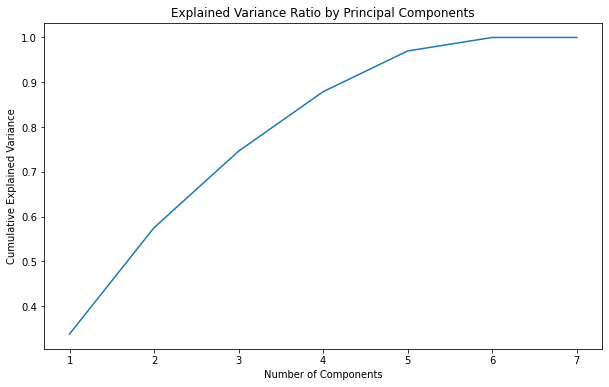

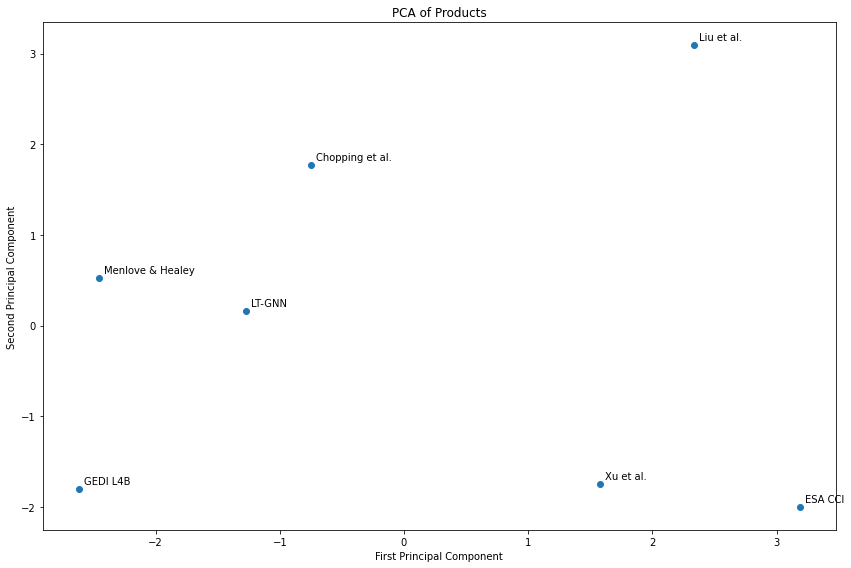

Feature Importance (based on first principal component):
           feature  importance
2            micro    0.432640
6   tropical_calib    0.432640
0        multispec    0.338738
11          ICESAT    0.318073
7              FIA    0.290863
10             GSV    0.274783
3            field    0.249012
9             NEON    0.225716
4               ML    0.212662
12         Saatchi    0.201215
5     forest_calib    0.201215
8              ALS    0.069612
13            MISR    0.064656
1            lidar    0.038007


In [15]:
pca_results, pca_obj, df_encoded = perform_pca_analysis(matrix, feature_cols, products)

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': df_encoded.columns,
    'importance': np.abs(pca_obj.components_[0])  # Using the first principal component
})
print("Feature Importance (based on first principal component):")
print(feature_importance.sort_values('importance', ascending=False))

50% of the variance is explained by the first two PC, and most of it is explained by the first 5. thus, products are not all unrelated. 

The points in the plot don't form a pattern, so there's no relationship between the principle components

The principle components are whether are not microspectral data was used as input or whether or not the product was calibrated with that included tropical regions

In [29]:
loadings=pca_obj.components_

explained_variance_ratio = pca_obj.explained_variance_ratio_

# Print loadings
print("Loadings:")
for i, component in enumerate(loadings):
    print(f"PC{i+1}:", ", ".join(f"{feature}: {loading:.3f}" for feature, loading in zip(feature_cols, component)))

# Print explained variance
print("\nExplained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.3f}")

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("\nCumulative Explained Variance Ratio:")
for i, ratio in enumerate(cumulative_variance_ratio):
    print(f"PC{i+1}: {ratio:.3f}")

Loadings:
PC1: multispec: 0.339, lidar: 0.038, micro: 0.433, field: -0.249, ML: 0.213, forest_calib: -0.201, tropical_calib: 0.433, FIA: -0.291, ALS: -0.070, NEON: -0.226, GSV: 0.275, ICESAT: 0.318, Saatchi: 0.201, MISR: -0.065
PC2: multispec: 0.122, lidar: -0.362, micro: -0.057, field: 0.065, ML: -0.311, forest_calib: -0.379, tropical_calib: -0.057, FIA: -0.249, ALS: -0.338, NEON: -0.221, GSV: -0.245, ICESAT: -0.356, Saatchi: 0.379, MISR: 0.218
PC3: multispec: -0.258, lidar: 0.293, micro: 0.113, field: -0.380, ML: -0.354, forest_calib: -0.305, tropical_calib: 0.113, FIA: -0.054, ALS: 0.321, NEON: 0.469, GSV: -0.091, ICESAT: -0.112, Saatchi: 0.305, MISR: -0.138
PC4: multispec: 0.065, lidar: 0.300, micro: -0.169, field: -0.314, ML: -0.181, forest_calib: 0.211, tropical_calib: -0.169, FIA: -0.447, ALS: -0.175, NEON: 0.095, GSV: 0.292, ICESAT: -0.022, Saatchi: -0.211, MISR: 0.550
PC5: multispec: 0.273, lidar: -0.360, micro: 0.046, field: -0.358, ML: 0.040, forest_calib: 0.113, tropical_ca

# Loading vectors arrow plot interp:
    
Axes:

    The x-axis represents the first principal component (PC1).
    The y-axis represents the second principal component (PC2).
    The scales on these axes represent the correlation between the variables and the principal components.


Arrows:

    Each arrow represents a variable from your original dataset.
    The direction of the arrow shows how that variable contributes to PC1 and PC2.
    The length of the arrow indicates the strength of the variable's contribution to these components.


Interpreting arrow directions:

    Arrows pointing in the same direction: Variables are positively correlated.
    Arrows pointing in opposite directions: Variables are negatively correlated.
    Arrows at right angles: Variables are likely uncorrelated.


Interpreting arrow lengths:

    Longer arrows: Variables have a stronger influence on the principal components.
    Shorter arrows: Variables have less influence on the principal components.


Quadrants:

    Variables in the same quadrant are positively correlated with each other.
    Variables in opposite quadrants are negatively correlated.


Proximity to axes:

    Arrows close to the PC1 axis (horizontal) contribute strongly to PC1.
    Arrows close to the PC2 axis (vertical) contribute strongly to PC2.


Origin:

    The further an arrow is from the origin (0,0), the more that variable contributes to the overall variance in the dataset.


Interpreting clusters of arrows:

    If several arrows cluster together, those variables behave similarly in your dataset.


Opposing arrows:

    If two arrows point in exactly opposite directions, those variables are likely strongly negatively correlated.


Perpendicular arrows:

    If two arrows are at right angles to each other, those variables are likely uncorrelated.

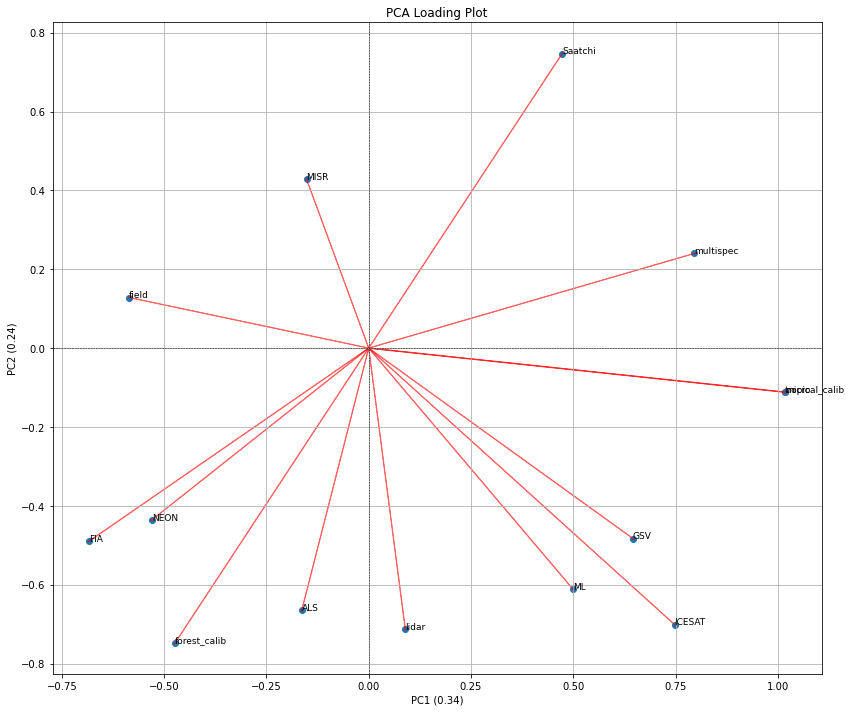

In [37]:
# Assuming you've already performed PCA
plot_loading_vectors(pca_obj, feature_cols)

#  loading vis

the "loadings" or "components"show how much each original variable contributes to each principal component.
shows the loadings for each principal component as a bar plot
negative loading for a variable means that it has an inverse relationship with the principal component

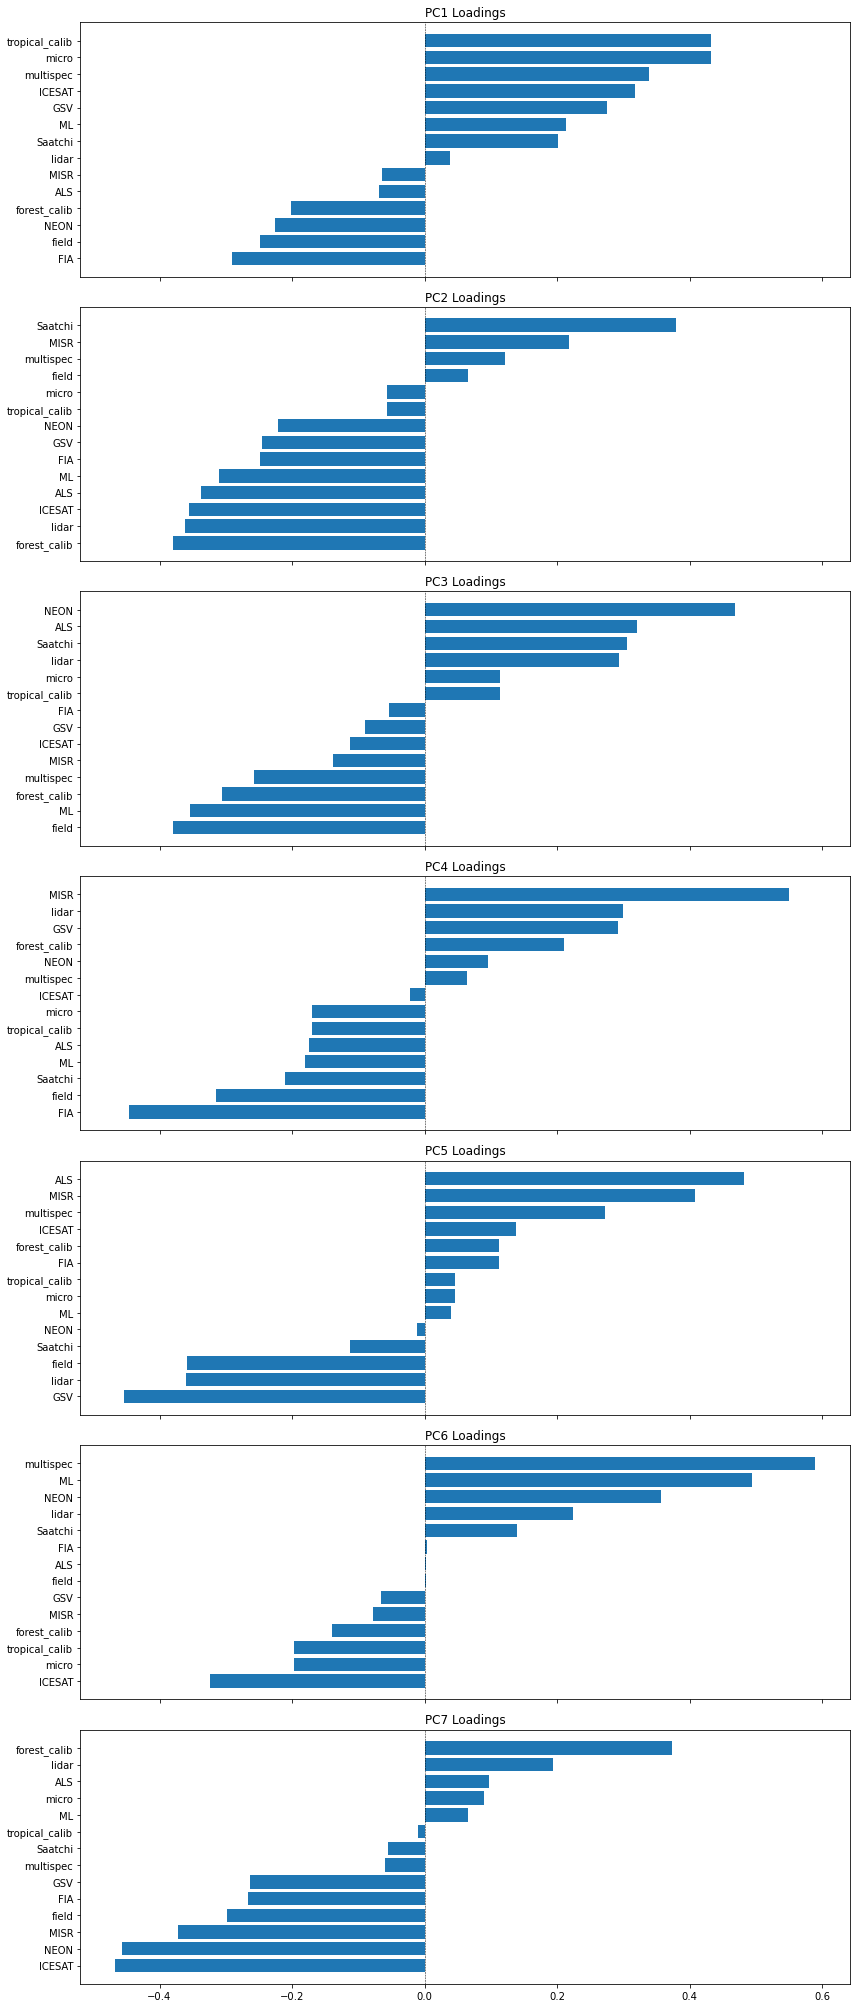

In [33]:
def plot_loading_bars(pca, feature_names, n_components=3):
    fig, axes = plt.subplots(n_components, 1, figsize=(12, 4*n_components), sharex=True)
    for i in range(n_components):
        loadings = pca.components_[i]
        sorted_idx = np.argsort(loadings)
        axes[i].barh(np.array(feature_names)[sorted_idx], loadings[sorted_idx])
        axes[i].set_title(f"PC{i+1} Loadings")
        axes[i].axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Assuming you've already performed PCA
plot_loading_bars(pca_obj, feature_cols, n_components=7)  # Adjust n_components as needed

In [30]:
#original grouping. using first function, and all new features

weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
similarity_threshold = 0.55

result = group_samples_by_similarity_threshold(matrix, weights, similarity_threshold, feature_cols, products)
print(result)

                  multispec  lidar  micro  field  ML  forest_calib  \
ESA CCI                   1      1      1      0   1             1   
Chopping et al.           1      0      0      0   0             1   
GEDI L4B                  0      1      0      0   0             1   
Liu et al.                1      0      1      0   0             0   
LT-GNN                    1      0      0      1   1             1   
Menlove & Healey          0      0      0      1   0             1   
Xu et al.                 1      0      1      0   1             1   

                  tropical_calib  FIA  ALS  NEON  GSV  ICESAT  Saatchi  MISR  \
ESA CCI                        1    0    0     0    1       1        0     0   
Chopping et al.                0    0    0     0    0       0        0     1   
GEDI L4B                       0    1    1     1    0       0        0     0   
Liu et al.                     1    0    0     0    0       0        1     0   
LT-GNN                         0    1  

# Determining appropriate similarity threshold

This can be done using multiple methods and inspection of results:

    elbow method - Look for an "elbow" in the resulting plot where the number of groups starts to level off
    silhouette - Choose the threshold that maximizes the silhouette score,  measures how similar an object is to its own
        cluster compared to other clusters
    hierarchical clustering - Examine the dendrogram to identify natural clusters and choose a threshold that creates these
        clusters

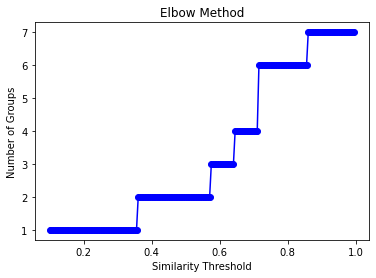

In [20]:
thresholds = np.arange(0.1, 1.0, 0.005)
elbow_method(matrix, weights, thresholds, feature_cols, products)

Invalid number of clusters (1) at threshold 0.1. Skipping.
Invalid number of clusters (1) at threshold 0.15000000000000002. Skipping.
Invalid number of clusters (1) at threshold 0.20000000000000004. Skipping.
Invalid number of clusters (1) at threshold 0.25000000000000006. Skipping.
Invalid number of clusters (1) at threshold 0.30000000000000004. Skipping.
Invalid number of clusters (1) at threshold 0.3500000000000001. Skipping.
Invalid number of clusters (7) at threshold 0.9000000000000002. Skipping.
Invalid number of clusters (7) at threshold 0.9500000000000003. Skipping.


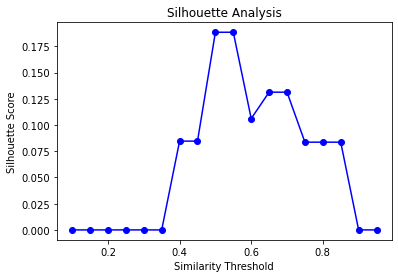

In [21]:
thresholds = np.arange(0.1, 1.0, 0.05)
silhouette_analysis(matrix, weights, thresholds)

In [22]:
similarity_matrix = weighted_hamming_similarity(matrix, weights)
similarity_matrix

array([[1.        , 0.5       , 0.35714286, 0.57142857, 0.5       ,
        0.35714286, 0.71428571],
       [0.5       , 1.        , 0.57142857, 0.64285714, 0.71428571,
        0.71428571, 0.5       ],
       [0.35714286, 0.57142857, 1.        , 0.35714286, 0.57142857,
        0.71428571, 0.5       ],
       [0.57142857, 0.64285714, 0.35714286, 1.        , 0.5       ,
        0.5       , 0.57142857],
       [0.5       , 0.71428571, 0.57142857, 0.5       , 1.        ,
        0.85714286, 0.64285714],
       [0.35714286, 0.71428571, 0.71428571, 0.5       , 0.85714286,
        1.        , 0.5       ],
       [0.71428571, 0.5       , 0.5       , 0.57142857, 0.64285714,
        0.5       , 1.        ]])

In [23]:
linkage_matrix = linkage(1 - similarity_matrix, method='average')
linkage_matrix

<ipython-input-23-4442d300463f>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - similarity_matrix, method='average')


array([[ 4.        ,  5.        ,  0.31943828,  2.        ],
       [ 0.        ,  6.        ,  0.47380354,  2.        ],
       [ 1.        ,  7.        ,  0.4843376 ,  3.        ],
       [ 2.        ,  9.        ,  0.63983183,  4.        ],
       [ 3.        ,  8.        ,  0.66235653,  3.        ],
       [10.        , 11.        ,  0.87109297,  7.        ]])

<ipython-input-4-a4377358be08>:135: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - similarity_matrix, method='average')


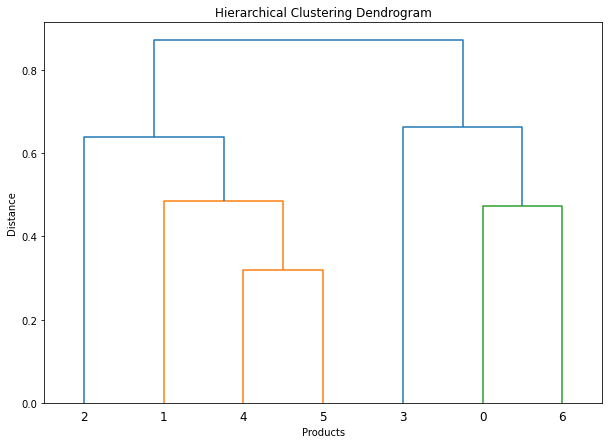

In [24]:
hierarchical_clustering(matrix, weights)

In [25]:
clusters = dbscan_clustering(matrix, weights)
print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")

Number of clusters: 1
